# Finding Cu crystal ground state via the Augmented Plane method

Adapted from Thijssen

In [70]:
import numpy as np
from scipy import special as sp
import matplotlib.pyplot as plt

In [33]:
# constants
a = 6.822 #au
R = 1
V = 3*(a**3)/4

l_max = 2*(3+2+1) +3
nLim = 3 

b1 = 2*np.pi*np.array([-1,1,1])/a
b2 = 2*np.pi*np.array([1,-1,1])/a
b3 = 2*np.pi*np.array([1,1,-1])/a
Ks =[l*b1 + m*b2 + n*b3 for l in range(-nLim,nLim+1) for m in range(-nLim,nLim+1) for n in range(-nLim,nLim+1)]



In [34]:
#generate A
A = np.empty([len(Ks),len(Ks)])
for i,K_i in enumerate(Ks):
    for j,K_j in enumerate(Ks):
        kDiff = np.linalg.norm(K_i-K_j)
        if kDiff == 0:
            A[i,j] = 1
        else:
            A[i,j] = -4*np.pi*(R**2)*sp.spherical_jn(1,kDiff*R)/(V*kDiff)

print(A)




[[ 1.00000000e+00 -1.35026863e-02 -5.09872972e-03 ...  1.43263837e-03
   1.46185786e-03  1.27006053e-03]
 [-1.35026863e-02  1.00000000e+00 -1.35026863e-02 ...  1.11366118e-03
   1.43263837e-03  1.46185786e-03]
 [-5.09872972e-03 -1.35026863e-02  1.00000000e+00 ...  3.37244015e-04
   1.11366118e-03  1.43263837e-03]
 ...
 [ 1.43263837e-03  1.11366118e-03  3.37244015e-04 ...  1.00000000e+00
  -1.35026863e-02 -5.09872972e-03]
 [ 1.46185786e-03  1.43263837e-03  1.11366118e-03 ... -1.35026863e-02
   1.00000000e+00 -1.35026863e-02]
 [ 1.27006053e-03  1.46185786e-03  1.43263837e-03 ... -5.09872972e-03
  -1.35026863e-02  1.00000000e+00]]


In [35]:
#shall use hydrogen atom approximation as all other electrons have a shielding effect (this is rough)

def iterateRK4(t_n,y_n,h,f):
    """
    Iterates by RK4 method.
    """
    k_1 = f(t_n, y_n)
    k_2 = f(t_n + h/2, y_n + h*k_1/2)
    k_3 = f(t_n + h/2, y_n + h*k_2/2)
    k_4 = f(t_n + h, y_n + h*k_3)

    return y_n + h*(k_1 + 2*k_2 + 2*k_3 + k_4)/6

def intialCond(l,r_0):
    #from small r solution to radial schrodinger eq, remember its u not R
    return np.array([r_0**(l+1),(l+1)*r_0**l])

def getfRadial(l,E):
    def f(r,y):
        u = y[0]
        p = y[1] #p = du/dr
        f_u = p
        f_p = (l*(l+1)/(r**2) - 2*E - 2/r)*u
        return np.array([f_u,f_p])
    return f
        
r_0 = 0.1
h = 0.05
def getRatio(l,E):
    rs = [r_0]
    ys = [intialCond(l,r_0)]
    for i in range(int((R - r_0)/h)):
        rs.append(rs[-1]+h)
        ys.append(iterateRK4(rs[-1],ys[-1],h,getfRadial(l,E)))
    
    yBoundary = ys[-1]
    return yBoundary[1]/yBoundary[0] - 1/R

In [58]:
def findDet(k,E):
    #set up k dependent matricies 
    B = np.empty([len(Ks),len(Ks)])
    C = np.empty([len(Ks),len(Ks),len(Ks)])
    qs = [k + K for K in Ks]

    #find B and C
    for i in range(len(Ks)):
        for j in range(len(Ks)):
            qDot = np.dot(qs[i],qs[j])
            B[i,j] = A[i,j]*qDot/2
            qi = np.linalg.norm(qs[i])
            qj = np.linalg.norm(qs[j])
            for l in range(l_max): 
                if qi == 0 or qj == 0:
                    C[i,j,l] = 0
                else: 
                    C[i,j,l] = (2*l + 1)*2*np.pi*(R**2)*sp.eval_legendre(l,qDot/(qi*qj))*sp.spherical_jn(l,qi*R)*sp.spherical_jn(l,qj*R)/V
    
    H = -E*A + B
    for l in range(l_max):
        H += C[:,:,l]*getRatio(l,E)

    #this function is more approriate for large matrices
    detData = np.linalg.slogdet(H - E*np.identity(len(Ks))) #returns in (sign,absolute val
    det = detData[0]*detData[1]
    return det


In [61]:
def findZero(lst):
    for i in range(1,len(lst)):
        if (lst[i-1]>0 and lst[i]<0) or (lst[i-1]<0 and lst[i]>0):
            return i
    return len(lst)

In [79]:


ks = [2*np.pi*np.array([i/10,0,0])/a for i in range(1,11)]
EMesh  = np.arange(-0.1,0.2,step=0.01)
Es = np.empty(len(ks))


for i,k in enumerate(ks):
    Es[i] = EMesh[int(findZero([findDet(k,E) for E in EMesh]))]
    print(Es[i])

print(Es)
    

-0.01000000000000005
-0.01000000000000005
-5.551115123125783e-17
0.019999999999999934
0.039999999999999925
0.059999999999999915
0.08999999999999989
0.11999999999999988
0.14999999999999988
0.17999999999999985
[-1.00000000e-02 -1.00000000e-02 -5.55111512e-17  2.00000000e-02
  4.00000000e-02  6.00000000e-02  9.00000000e-02  1.20000000e-01
  1.50000000e-01  1.80000000e-01]


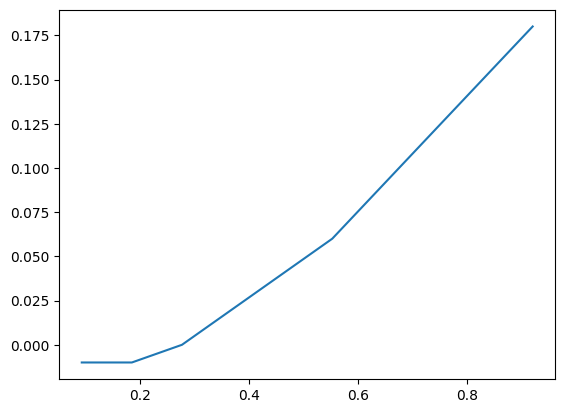

In [81]:

plt.plot(list(map(lambda k: k[0],ks)),Es)